In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IFCC.data.datapipes as dp
import IFCC.data.tepmanip as tepmanip
import pyreadr as pyr
import importlib
import IFD.units.variational.SS_RNN as SS_RNN
import IFD.support.training as train
from typing import Iterable
import IFD.losses.variational.LossesAndMetrics as loss
import IFCC.models.encoders as enc
import matplotlib.gridspec as gridspec
import pdb
import IFD.detection.varfd as fd
from ipywidgets import interact
import ipywidgets as widgets


2023-12-24 10:33:05.038913: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-24 10:33:05.067205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-24 10:33:05.187633: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-24 10:33:05.188330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 10:33:06.082968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [36]:
#importlib.reload(SS_RNN)
importlib.reload(train)
importlib.reload(dp)
importlib.reload(loss)
importlib.reload(tepmanip)
importlib.reload(enc)
importlib.reload(fd)

<module 'IFD.detection.varfd' from '/home/melbelta/PycharmProjects/IFDC-brnn/IFD/detection/varfd.py'>

<font size="12"> Reading and processing TEP data </font>

In [2]:
p_ntr='../IFCC/data/tep_source_data/TEP_FaultFree_Training.RData'
p_nval='../IFCC/data/tep_source_data/TEP_FaultFree_Testing.RData'
tep_ntr_Rdata=pyr.read_r(path=p_ntr)
tep_nval_Rdata=pyr.read_r(path=p_nval)

In [3]:
cols_no_norm=['sample_id','faultNumber']

#get and normalize TEP training data
tep_ntr=tepmanip.tep_rdata_to_pd(tep_rdata=tep_ntr_Rdata)
tep_ntr=tepmanip.get_tep_data_fixedsimrun(tep_data=tep_ntr,sim_run=1)
tep_ntr=tepmanip.unify_tepdata_columns_order(tep_ntr)

X_tr,norm_params,_=tepmanip.normalize_data(data=tep_ntr,kept_columns=cols_no_norm)

#get TEP validation data
tep_nval=tepmanip.tep_rdata_to_pd(tep_rdata=tep_nval_Rdata)
tep_nval=tepmanip.get_tep_data_fixedsimrun(tep_data=tep_nval,sim_run=1)
tep_nval=tepmanip.unify_tepdata_columns_order(tep_nval)
#split the validation data into testing and validation set and normalize both 
tep_nval,tep_nts=tepmanip.split_tep_data(tep_data=tep_nval,split_frac=.5)
X_val,X_ts=tepmanip.apply_norm(data=[tep_nval,tep_nts],norm_params=norm_params,kept_columns=cols_no_norm)


# #large dataset
# tep_na=tepmanip.tep_rdata_to_pd(tep_rdata=tep_n_Rdata)
# tep_na=tepmanip.unify_tepdata_columns_order(tep_data=tep_na)
# tep_ntra,other=tepmanip.split_tep_data(tep_data=tep_na,split_frac=0.6) #split the data
# tep_nvala,tep_ntsa=tepmanip.split_tep_data(tep_data=other,split_frac=.5)
# X_tra,norm_paramsa=tepmanip.normalize_data(data=tep_ntra)
# X_vala,X_tsa=tepmanip.apply_norm(data=[tep_nvala,tep_ntsa],norm_params=norm_paramsa)

# X_tra['sample_id']=tep_ntra['sample_id']
# X_vala['sample_id']=tep_nvala['sample_id']
# X_tsa['sample_id']=tep_ntsa['sample_id']


In [4]:
#thid code reads the full faulty dataset for a specific simulation run, and extractes a subset corresponding to each type pf fault 
p_ftr='../IFCC/data/tep_source_data/TEP_Faulty_Training.RData'
tep_ftr_rdata=pyr.read_r(p_ftr)
#for some reason the faulty testing data won't be read
#the file is too big that its causing the session to crash
p_fts='../IFCC/data/tep_source_data/TEP_Faulty_Testing.RData'
#tep_fts=pyr.read_r(p_fts) #TODO: fix the crashing session probelm 



In [5]:
tep_ftr=tepmanip.tep_rdata_to_pd(tep_rdata=tep_ftr_rdata)
#tep_fts=tepmanip.tep_rdata_to_pd(tep_rdata=tep_fts)

tep_ftr=tepmanip.get_tep_data_fixedsimrun(tep_data=tep_ftr,sim_run=1)

num_fault_types=20
faulty_l_tr_data=[]
faulty_l_ts_data=[]

for i in range(num_fault_types):
    
    fi_tr_data=tepmanip.get_single_fault_data(tep_data=tep_ftr,fault_number=(i+1))
    fi_tr_data=tepmanip.unify_tepdata_columns_order(tep_data=fi_tr_data)
    #normalization code goes here
    fi_tr_data=tepmanip.apply_norm(data=[fi_tr_data],norm_params=norm_params,kept_columns=cols_no_norm)
    fi_tr_data=fi_tr_data[0]
    #pdb.set_trace()
    #fi_tr_data=tepmanip.insert_fault_idx(tep_data=fi_tr_data,fault_injection_time=8, sampling_period=3) #TODO: instead of inserting an index to the TEP pd.DataFrame, I will write a function that returns the faulty samples index separately
    faulty_l_tr_data.append(fi_tr_data)
    #faulty_l_ts_data.append(fi_ts_data)

In [6]:
tep_dp=dp.TepDataPipe(input_width=10,label_width=10,shift=1,tr_data= X_tr, val_data= X_val, test_data=X_ts,target_names=None, sampling_rate= 1, batch_size = 64, shuffle_flag  = False)

In [7]:
tep_aid_dp=dp.TepDataPipe(input_width=10,label_width=10,shift=1,tr_data= X_tr, val_data= X_val, test_data=X_ts,target_names=None, sampling_rate= 1, seqeunce_stride=10,batch_size = 32, shuffle_flag  = False)

<font size="12"> Training the SS-RNN model using prediction loss </font>

In [8]:
k=tep_dp.example[0].shape[-1] #output shape
n=52#num of hidden states
ss_mdl=SS_RNN.SsRnnMdl(ss_layer=SS_RNN.SsLayer(num_states=n,output_dimension=k))
ss_mdl_s=SS_RNN.SsRnnMdl(ss_layer=SS_RNN.SsLayerSout(num_states=n,output_dimension=k))
lstm_mdl=keras.Sequential([keras.layers.LSTM(units=n,return_sequences=True),keras.layers.Dense(units=k)])

2023-12-24 10:33:35.840979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [490]
	 [[{{node Placeholder/_8}}]]
2023-12-24 10:33:35.841257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]


TypeError: SsLayer.__init__() missing 1 required positional argument: 'ss_cell'

In [ ]:
ex_i,ex_o=tep_dp.example
Y1=ss_mdl_s(ex_i)

In [ ]:

h=train.compile_and_fit(ss_mdl_s,tep_dp,loss_fn=loss.variational_log_likelihood,max_epochs=200,patience=20,prof_call_back=None)
#h=train.compile_and_fit(lstm_mdl,tep_dp,loss_fn=keras.losses.MeanSquaredError(),metric=keras.metrics.MeanAbsoluteError(),prof_call_back=None,patience=100,max_epochs=200)

2023-11-17 09:50:48.808765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [47]
	 [[{{node Placeholder/_8}}]]
2023-11-17 09:50:48.809123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [480,52]
	 [[{{node Placeholder/_0}}]]


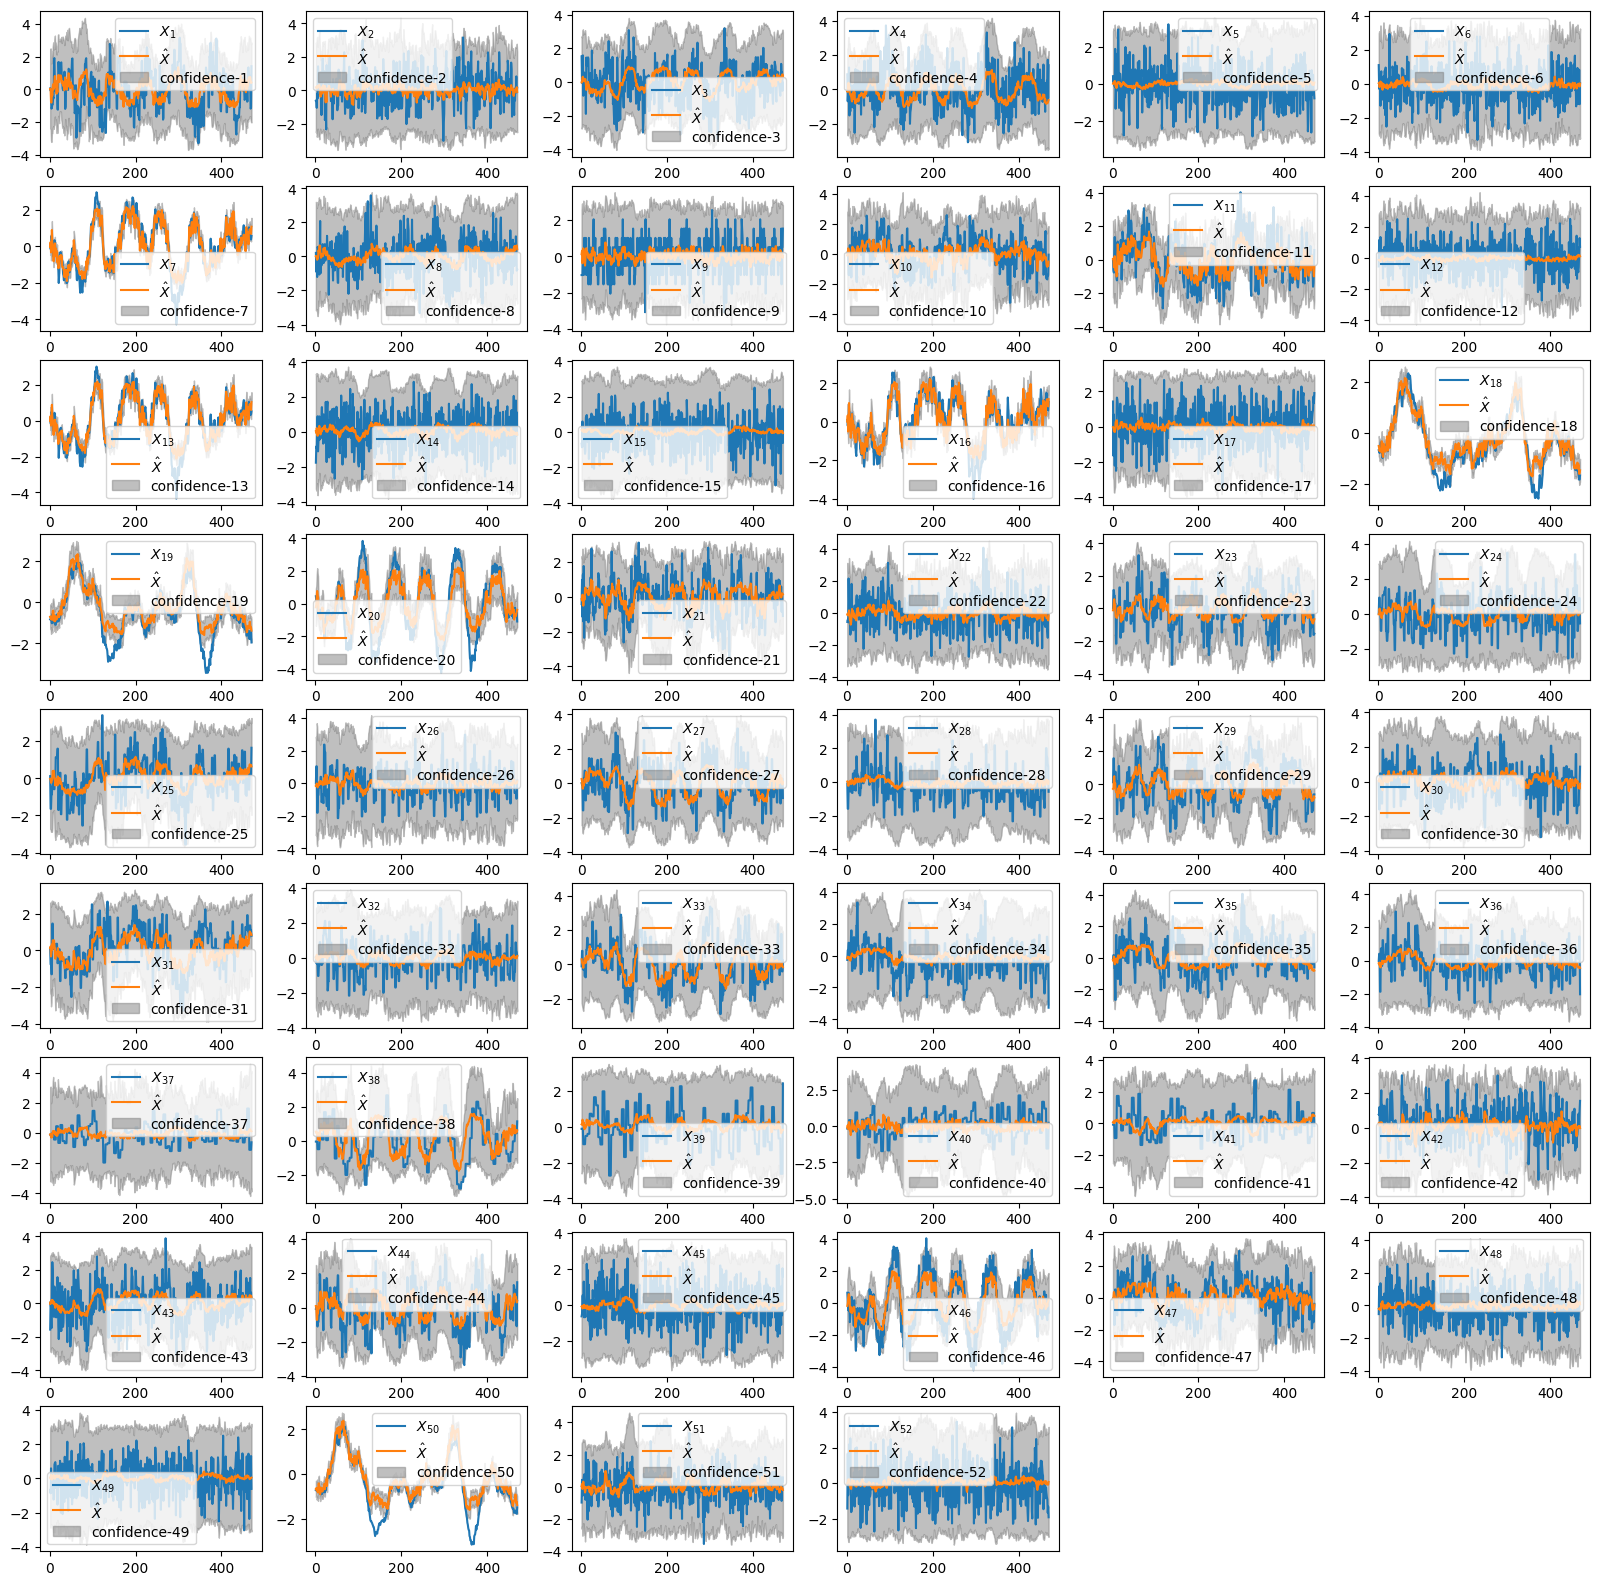

In [14]:

_=loss.visualize_model_results(dataset=tep_aid_dp.val_ds,mdl=ss_mdl_s,conf_width=3)

<font size="12"> Fault Detection and Analysis </font>

In [15]:
#extract TEP process variables data only for a single fault (during testing)
tep_vars_cols=slice(1,-1) #this will exclude the the sample_id and faultNumber columns
cols_to_keep=faulty_l_tr_data[0].columns[tep_vars_cols]
#
temp_f1_data=faulty_l_tr_data[0][cols_to_keep].to_numpy(dtype='float32')
true_fault_state=tepmanip.get_samples_fault_state(tep_data=temp_f1_data, fault_injection_time=8)

mahala_thresh=20 #I will use an interactive slide bar to study the effect of the threshold on the results
z_thresh=3

def visualize_fault_rc_analysis(z_score_list,anomaly_source_list):
    z_score_mat=np.concatenate([z_score_list],axis=1).T
    anomaly_source_mat=np.concatenate([anomaly_source_list],axis=1).T

    gs=gridspec.GridSpec(nrows=2,ncols=2,width_ratios=[1,0.05],height_ratios=[1,1])
    _=plt.figure(figsize=(40,40))

    ax1=plt.subplot(gs[0,0])
    ax1.set_xlabel('Sample',fontsize=30)
    ax1.set_ylabel('Process vars',fontsize=30)
    im1=ax1.imshow(z_score_mat)
    cbar_ax=plt.subplot(gs[0,1])
    plt.colorbar(im1,cbar_ax)


    ax2=plt.subplot(gs[1,0])
    ax2.set_xlabel('Sample',fontsize=30)
    ax2.set_ylabel('Process vars',fontsize=30)
    im2=plt.imshow(anomaly_source_mat,cmap='gray')
    cbar_ax=plt.subplot(gs[1,1])
    plt.colorbar(im2,cbar_ax)

    plt.show(_)

In [16]:

m,f,z,c=fd.detect_fault(ss_rnn=ss_mdl_s,data=temp_f1_data,mahala_thresh=mahala_thresh,z_thresh=z_thresh)

fpr,fnr,sensitivity,specifity,accuracy=fd.get_fault_detection_metric(target_fault_state=true_fault_state,predicted_fault_state=f)

In [1]:
@interact(mahala_thresh=widgets.IntSlider(value=10,min=0,max=60,step=2),z_thresh=widgets.IntSlider(value=3,min=0,max=6,step=1))
def temp_func(mahala_thresh,z_thresh):
    m,f,z,c=fd.detect_fault(ss_rnn=ss_mdl_s,data=temp_f1_data,mahala_thresh=mahala_thresh,z_thresh=z_thresh)
    visualize_fault_rc_analysis(z,c)

NameError: name 'interact' is not defined

<font size="12"> Join training using prediction and reconstruction loss </font>

In [12]:
class Ss_Lstm_Ae(keras.Model):

    def __init__(self,ss_rnn,lstm_decoder,**kwargs):

        super().__init__(**kwargs)
        self.ss_rnn=ss_rnn
        self.decoder=lstm_decoder

    def call(self,x):

        y,latent_vec=self.ss_rnn(x)
        reconst=self.decoder(latent_vec)

        return [y,reconst]


In [18]:

ex_i,ex_o= tep_dp.example

k=ex_i.shape[-1] #output shape
n=52#num of hidden states

ss_mdl=SS_RNN.SsRnnMdl(ss_layer=SS_RNN.SsLayer(num_states=n,output_dimension=k),name='ss_rnn')

lstm_deco=enc.LSTM_Decoder(target_shape=ex_i.shape[1:],units=52,name='lstm_decoder')

temp_ae=Ss_Lstm_Ae(ss_rnn=ss_mdl,lstm_decoder=lstm_deco,name='temp_ae')

Y,reconst=temp_ae(ex_i) #this is done to create the weights within the build method


In [19]:
cost=keras.losses.MeanAbsoluteError()
MAE=keras.metrics.MeanAbsoluteError()
op=tf.keras.optimizers.legacy.Adam()

In [25]:
def joint_train_ssrnn_ae(ss_rnn_ae,datapipe,reconstruction_loss,prediction_loss,perf_metric,optimizer,**kwargs):


    #set the training parameters
    num_epochs=kwargs.get('max_epochs',None)
    assert num_epochs is not None, 'Make sure to use the argument max_epochs'

    #initialize the performance metrics
    tr_pred_metric=perf_metric
    tr_reconst_metric=perf_metric
    val_pred_metric=perf_metric
    val_reconst_metric=perf_metric
    
    
    #initialize the epoch loss lists
    #these lists will store the mean loss at each epoch 
    epoch_tr_pred_loss,epoch_tr_reconst_loss=[],[]
    epoch_val_pred_loss,epoch_val_reconst_loss=[],[]
    
    #initialize the result dictionary 
    dic_items=['tr_pred_loss','tr_reconst_loss','val_pred_loss','val_reconst_loss']
    
    #
    #optimizer.build(ss_rnn_ae.trainable_weights)
    
    for epoch in tf.range(num_epochs):
        
        #initialize the step loss lists
        #these lists will store the loss at each step 
        step_tr_pred_loss,step_tr_reconst_loss=[],[]
        step_val_pred_loss,step_val_reconst_loss=[],[]
        
        for tr_step,(tr_in,tr_out) in enumerate(datapipe.train_ds):
            
            tr_in=tf.cast(tr_in,dtype='float32') #TODO: temporary solution to the data type mismatch problem
            tr_out=tf.cast(tr_out,dtype='float32')
            
            #take a training step and start recording the forward pass
            with tf.GradientTape(persistent=True) as tp:
                
                #forward pass
                prediction_seq,reconstructed_input=ss_rnn_ae(tr_in)
                
                #loss calculation
                l_p=prediction_loss(tr_out,prediction_seq)
                l_r=reconstruction_loss(tr_in,reconstructed_input)
                #l=l_p+l_r not needed at the moment 

            #update the paramters of the ss_rnn model using the prediction loss    
            grads_p=tp.gradient(l_p,ss_rnn_ae.ss_rnn.trainable_weights)
            optimizer.apply_gradients(zip(grads_p,ss_rnn_ae.ss_rnn.trainable_weights))
            
            #update the paramters of the ss_rnn and the decoder using the reconstruction loss
            grads_r=tp.gradient(l_r,ss_rnn_ae.trainable_weights)
            optimizer.apply_gradients(zip(grads_r,ss_rnn_ae.trainable_weights))
            
            
            
            
            #update the step training loss lists
            step_tr_pred_loss.append(l_p)
            step_tr_reconst_loss.append(l_r)
            
            #update the training perfromance metrics 
            tr_pred_metric.update_state(tr_out,prediction_seq)
            tr_reconst_metric.update_state(tr_in,reconstructed_input)
            
            
            
            
        for val_step,(val_in,val_out) in enumerate(datapipe.val_ds):
            
            val_in=tf.cast(val_in,dtype='float32') #TODO: temporary solution to the data type mismatch problem
            val_out=tf.cast(val_out,dtype='float32')
            
            
            prediction_seq,reconstructed_input=ss_rnn_ae(val_in)
            
            l_p=prediction_loss(val_out,prediction_seq)
            l_r=reconstruction_loss(val_in,reconstructed_input)
            
            
            #update the step validation loss lists
            step_val_pred_loss.append(l_p)
            step_val_reconst_loss.append(l_r)
            
            
            #update the validation perfromance metrics 
            val_pred_metric.update_state(val_out,prediction_seq)
            val_reconst_metric.update_state(val_in,reconstructed_input)
            
        
        
        #update the epoch training and validation loss lists
        epoch_tr_pred_loss.append(tf.reduce_mean(step_tr_pred_loss))
        epoch_tr_reconst_loss.append(tf.reduce_mean(step_tr_reconst_loss))
        
        epoch_val_pred_loss.append(tf.reduce_mean(step_val_pred_loss))
        epoch_val_reconst_loss.append(tf.reduce_mean(step_val_reconst_loss))
        
        
        
        
        template='Epoch {}, training_prediction_MAE: {:.2f}, training_reconstruction_MAE: {:.2f}, validation_prediction_MAE: {:.2f}, validation_reconstruction_MAE: {:.2f}'
        print(template.format(epoch,tr_pred_metric.result(),tr_reconst_metric.result(),val_pred_metric.result(),val_reconst_metric.result()))
        
        #reset the performance metrics for the next epoch 
        tr_pred_metric.reset_states()
        tr_reconst_metric.reset_states()
        val_pred_metric.reset_states()
        val_reconst_metric.reset_states()
        
        
    all_epoch_loss_list=[epoch_tr_pred_loss,epoch_tr_reconst_loss,epoch_val_pred_loss,epoch_val_reconst_loss]    
    history={key_name:value for key_name,value in zip(dic_items,all_epoch_loss_list)}

    return history
        
        
        
        
        
    
    
    

In [ ]:
h=joint_train_ssrnn_ae(ss_rnn_ae=temp_ae,datapipe=tep_dp,reconstruction_loss=cost,prediction_loss=loss.variational_log_likelihood,perf_metric=MAE,optimizer=op,max_epochs=200)

In [42]:
r,t=enc.visualize_ae_reconstruction(tep_aid_dp.train_ds,temp_ae)

2023-11-13 10:35:14.222831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [49]
	 [[{{node Placeholder/_8}}]]
2023-11-13 10:35:14.223327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]


In [53]:
class temp_ae(keras.Model):
    
    def __init__(self,ss_rnn,lstm_deco,**kwargs):
        super().__init__(**kwargs)
        self.ss_rnn=ss_rnn
        self.decoder=lstm_deco
        
    def call(self,x):
        
        _,latent_rep=self.ss_rnn(x)
        return self.decoder(latent_rep)
        

In [54]:
ss_mdl=SS_RNN.SsRnnMdl(ss_layer=SS_RNN.SsLayer(num_states=n,output_dimension=k),name='ss_rnn')
lstm_deco=enc.LSTM_Decoder(target_shape=ex_i.shape[1:],units=52,name='lstm_decoder')




In [55]:
t_ae=temp_ae(ss_mdl,lstm_deco)

In [60]:
train.compile_and_fit(t_ae,tep_dp,loss_fn=keras.losses.MeanSquaredError(),metric=keras.metrics.MeanAbsoluteError(),max_epochs=200,patience=20,prof_call_back=None)
#

Epoch 1/200


2023-11-13 10:57:17.968974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-11-13 10:57:17.969419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [490]
	 [[{{node Placeholder/_8}}]]


5/8 [=================>............] - ETA: 0s - loss: 0.7694 - mean_absolute_error: 0.6812 

2023-11-13 10:57:20.389659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-11-13 10:57:20.390138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [470]
	 [[{{node Placeholder/_8}}]]


8/8 [==============================] - 3s 62ms/step - loss: 0.7685 - mean_absolute_error: 0.6828 - val_loss: 0.9957 - val_mean_absolute_error: 0.7900
Epoch 2/200
8/8 [==============================] - 0s 23ms/step - loss: 0.7664 - mean_absolute_error: 0.6823 - val_loss: 0.9979 - val_mean_absolute_error: 0.7903
Epoch 3/200
8/8 [==============================] - 0s 25ms/step - loss: 0.7620 - mean_absolute_error: 0.6801 - val_loss: 0.9888 - val_mean_absolute_error: 0.7865
Epoch 4/200
8/8 [==============================] - 0s 28ms/step - loss: 0.7587 - mean_absolute_error: 0.6774 - val_loss: 0.9909 - val_mean_absolute_error: 0.7877
Epoch 5/200
8/8 [==============================] - 0s 26ms/step - loss: 0.7582 - mean_absolute_error: 0.6777 - val_loss: 0.9955 - val_mean_absolute_error: 0.7880
Epoch 6/200
8/8 [==============================] - 0s 31ms/step - loss: 0.7567 - mean_absolute_error: 0.6760 - val_loss: 0.9908 - val_mean_absolute_error: 0.7875
Epoch 7/200
8/8 [=======================

2023-11-13 11:09:43.057500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [49]
	 [[{{node Placeholder/_8}}]]
2023-11-13 11:09:43.057886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [500,52]
	 [[{{node Placeholder/_0}}]]


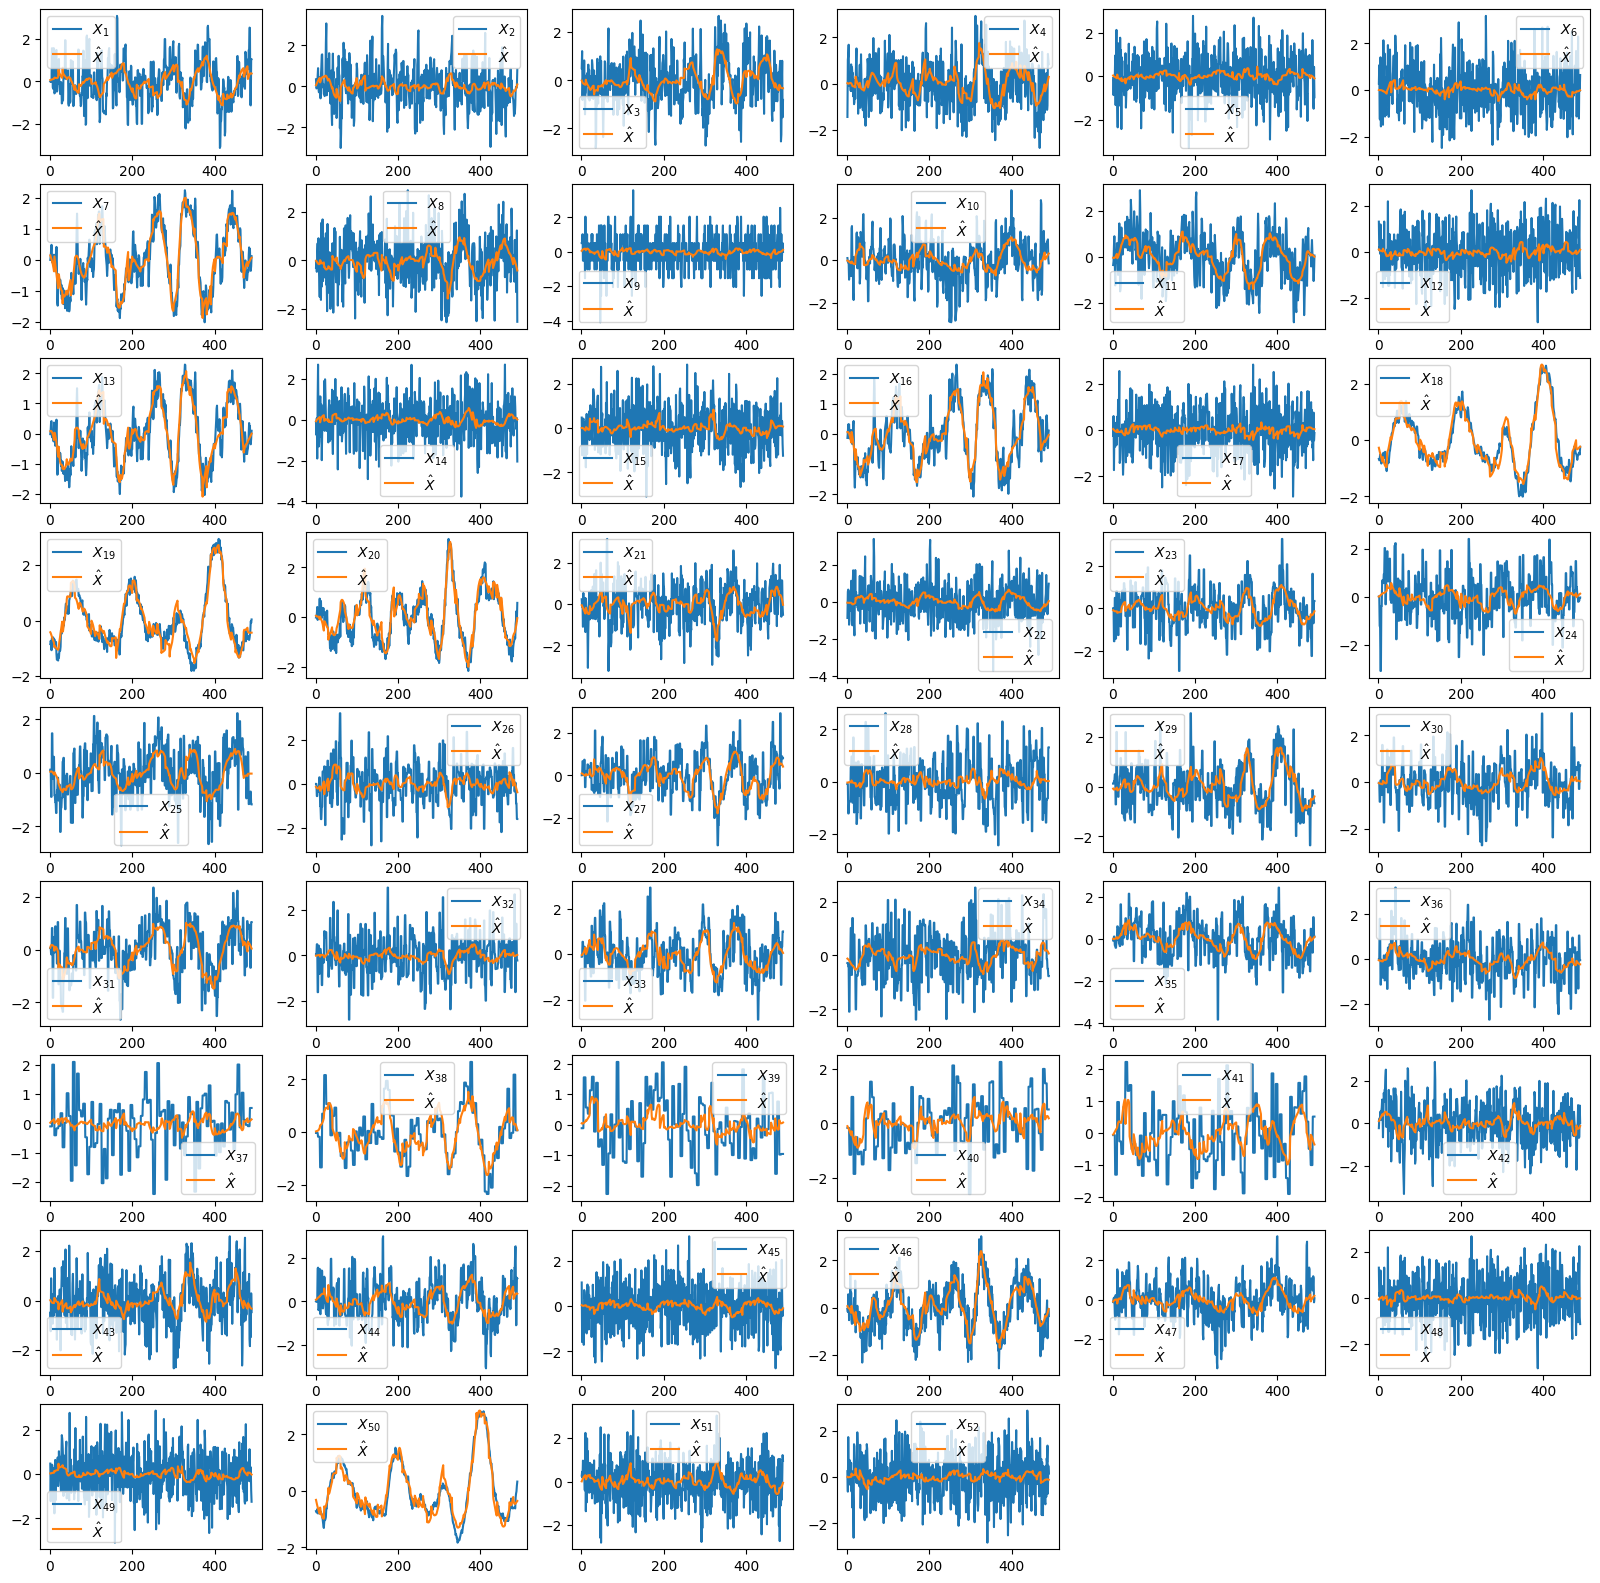

In [72]:
ax=enc.visualize_reconstruction(tep_aid_dp.train_ds,t_ae)